In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # <-- MUDANÇA: Importamos o RandomForest
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Carregar a tabela de modelagem final (com todas as features)
path_final_table = '../data/processed/modeling_table_v2.parquet'
df = pd.read_parquet(path_final_table)
print(f"Tabela de modelagem carregada com {df.shape[0]} dias e {df.shape[1]} colunas.")

# 1. Separar Features (X) e Alvo (y)
y = df['nivel_risco']
X = df.drop(columns=['nivel_risco', 'deficit_diario_mwh'])

# 2. Codificar o Alvo e Dividir em Treino/Teste
print("\n--- Contagem de dias por classe de risco ---")
print(y.value_counts())
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 3. Escalonar as Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar SMOTE nos dados de treino
print("\n--- Aplicando SMOTE nos dados de treino ---")
min_class_count = y_train.value_counts().min()
k_neighbors_smote = max(1, min_class_count - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Contagem de classes de treino DEPOIS do SMOTE:")
print(y_train_resampled.value_counts())

print("\nPreparação dos dados concluída.")

Tabela de modelagem carregada com 1343 dias e 22 colunas.

--- Contagem de dias por classe de risco ---
nivel_risco
baixo    1315
medio      18
alto       10
Name: count, dtype: int64

--- Aplicando SMOTE nos dados de treino ---
Contagem de classes de treino DEPOIS do SMOTE:
nivel_risco
0    920
2    920
1    920
Name: count, dtype: int64

Preparação dos dados concluída.


In [3]:
# --- MUDANÇA: Usamos o RandomForestClassifier ---
# n_estimators: número de "árvores" na floresta.
# class_weight='balanced': Ajuda o modelo a dar mais importância para as classes raras.
# n_jobs=-1: Usa todos os processadores para acelerar o treinamento.
model_rf = RandomForestClassifier(
    n_estimators=200, 
    class_weight='balanced',
    random_state=42, 
    n_jobs=-1
)

# Treinamos o modelo com os dados de treino AUMENTADOS pelo SMOTE.
print("Treinando o modelo RandomForest...")
model_rf.fit(X_train_resampled, y_train_resampled)
print("Treinamento concluído.")

Treinando o modelo RandomForest...
Treinamento concluído.


Fazendo previsões com o RandomForest no conjunto de teste...

Acurácia do Modelo RandomForest: 95.53%

Relatório de Classificação (RandomForest):
              precision    recall  f1-score   support

       baixo       0.98      0.97      0.98       395
       medio       0.00      0.00      0.00         5
        alto       0.00      0.00      0.00         3

    accuracy                           0.96       403
   macro avg       0.33      0.32      0.33       403
weighted avg       0.96      0.96      0.96       403



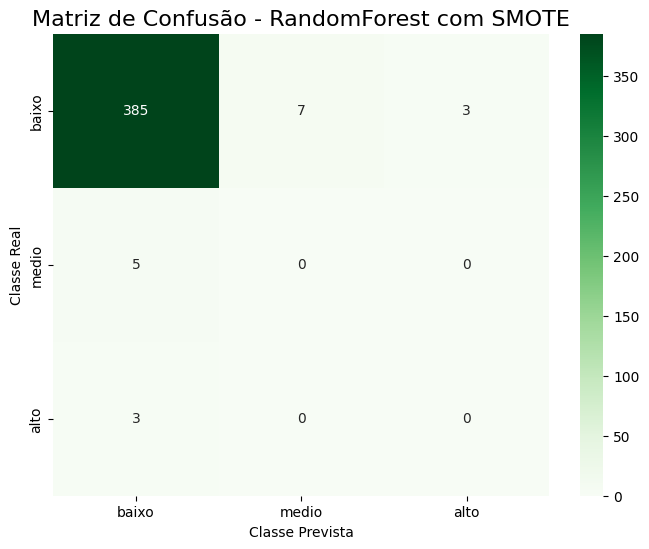

In [4]:
# Fazemos previsões no conjunto de teste ORIGINAL.
print("Fazendo previsões com o RandomForest no conjunto de teste...")
y_pred_rf = model_rf.predict(X_test_scaled)

print(f"\nAcurácia do Modelo RandomForest: {accuracy_score(y_test, y_pred_rf):.2%}\n")
print("Relatório de Classificação (RandomForest):")
print(classification_report(y_test, y_pred_rf, target_names=mapeamento_risco.keys()))

# Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title('Matriz de Confusão - RandomForest com SMOTE', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

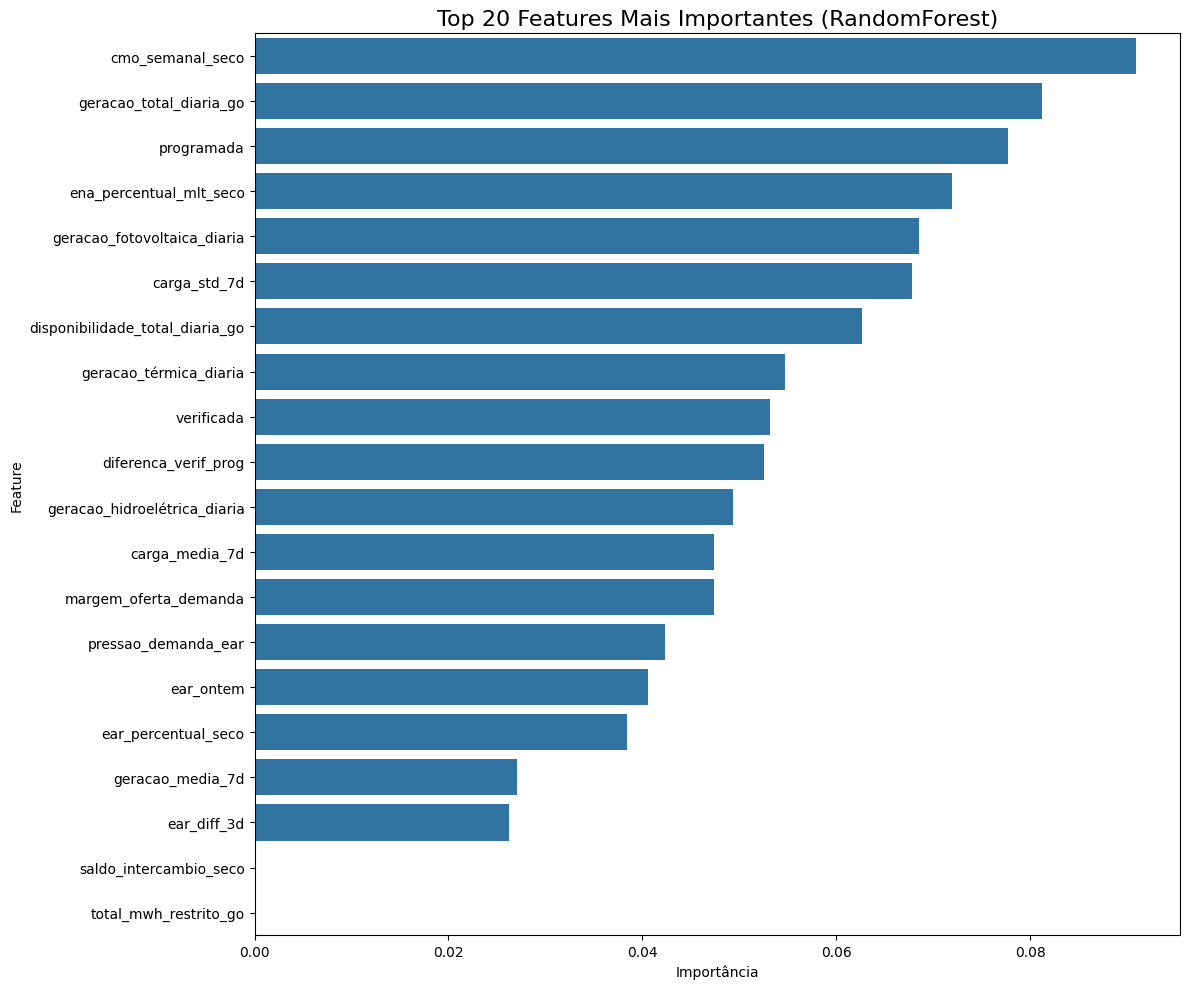

In [5]:
# O RandomForest também nos diz quais features foram mais importantes.
importances_rf = model_rf.feature_importances_
feature_names = X.columns

feature_importance_df_rf = pd.DataFrame({'feature': feature_names, 'importance': importances_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df_rf.head(20)) # Mostra as 20 mais importantes
plt.title('Top 20 Features Mais Importantes (RandomForest)', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()